In [468]:
import pandas as pd
import pickle
from nltk import ngrams

In [469]:
with open("list_ner.pkl", "rb") as f:
    data = pickle.load(f)

In [335]:
for doc in data:
    for line in doc:
        line.pop("spacy", None)
        line.pop("+1:spacy", None)
        line.pop("-1:spacy", None)

In [470]:
for doc in data:
    for line in doc:
        for key in line.keys():
            assert "spacy" not in key

AssertionError: 

# CRFSuite format

In [241]:
excluded = ["token", "filename", "label"]

In [242]:
len(data)

115

In [243]:
data[0][1]

{'token': ',',
 'filename': 'allen-p_all_documents_113.txt',
 'label': 'no_entity',
 'email': False,
 'url': False,
 'num': False,
 'stop': False,
 'alpha': False,
 'title': False,
 'first': False,
 'last': False,
 'job': False,
 'job_part': False,
 'spacy': 'no_entity',
 'prefix3': ',',
 'line_prefix3': 'Sin',
 'line_suffix3': 'y,\n',
 'shape': ','}

In [245]:
def get_features(token):
    return {k:v for k, v in token.items() if k not in excluded}
#     return {k:v for k, v in token.items()}

In [246]:
def get_features_and_labels(token):
    label = token.pop("label")
    features = get_features(token)
    return label, features

In [247]:
def get_list_value(ls, i, default=None):
    try:
        return ls[i]
    except IndexError as ex:
        return default

In [248]:
def features_labels_ngrams(indices):
    main = []
    X = []
    y = []
    for idx in indices:
        doc = data[idx]
        main.append(doc)
        curr_y = []
        curr_X = []
        
        for i, curr_token in enumerate(doc):
            prev_token = get_list_value(doc, i-1)
            next_token = get_list_value(doc, i+1)
            
            curr_label, curr_features = get_features_and_labels(curr_token.copy())
            
            if prev_token and i > 0:
                for k, v in get_features(prev_token).items():
                    curr_features[f"-1:{k}"] = v
            else:
                curr_features["BOS"] = True
                
            if next_token:
                for k, v in get_features(next_token).items():
                    curr_features[f"+1:{k}"] = v
            else:
                curr_features["EOS"] = True                           
            
            curr_y.append(curr_label)
            curr_X.append(curr_features)
        y.append(curr_y)
        X.append(curr_X)
    return main, X, y

In [244]:
from sklearn.model_selection import train_test_split
train_idx, test_idx = train_test_split(range(len(data)), test_size=0.2, random_state=42)

In [471]:
multilabel_y = []
for doc in data:
    multilabel_y.append([line["label"] for line in doc])
assert len(data) == len(multilabel_y)
from sklearn.preprocessing import MultiLabelBinarizer
multilabel_y = MultiLabelBinarizer().fit_transform(multilabel_y)

from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
msss = MultilabelStratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=42)
train_index, test_index = msss.split(range(len(data)), multilabel_y)

G:\Programs\Anaconda2\envs\thesis-enron\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass test_size=0.2, train_size=None, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [472]:
# train, X_train, y_train = features_labels_ngrams(train_idx)
train, X_train, y_train = features_labels_ngrams(train_index[0])
test, X_test, y_test = features_labels_ngrams(train_index[1])

In [321]:
old_counts_train = Counter([y for x in y_train for y in x])
old_counts_test = Counter([y for x in y_test for y in x])

In [521]:
new_counts_train = Counter([y for x in y_train for y in x])
new_counts_test = Counter([y for x in y_test for y in x])

In [329]:
for label, counts in old_counts_train.items():
    test_counts = old_counts_test[label]
    print(f"{label:<10}: {counts/sum(old_counts_train.values()):.2f} --> {test_counts/sum(old_counts_test.values()):.2f}")

no_entity : 0.64 --> 0.51
PERSON    : 0.09 --> 0.21
ORG       : 0.05 --> 0.091
TITLE     : 0.02 --> 0.027
DIV       : 0.02 --> 0.018
URL       : 0.01 --> 0.0091
EMAIL     : 0.01 --> 0.0091
PHONE     : 0.08 --> 0.11
FAX       : 0.03 --> 0.0
ADDRESS   : 0.06 --> 0.018


In [522]:
for label, counts in new_counts_train.items():
    test_counts = new_counts_test[label]
    print(f"{label:<10}: {counts/sum(new_counts_train.values()):.2f} --> {test_counts/sum(new_counts_test.values()):.2f}")

no_entity : 0.66 --> 0.48
PERSON    : 0.09 --> 0.12
TITLE     : 0.02 --> 0.04
ORG       : 0.05 --> 0.07
ADDRESS   : 0.05 --> 0.09
PHONE     : 0.08 --> 0.10
FAX       : 0.03 --> 0.04
EMAIL     : 0.01 --> 0.02
DIV       : 0.02 --> 0.03
URL       : 0.01 --> 0.02


In [339]:
train_filenames = [token["filename"] for doc in train for token in doc]
test_filenames = [token["filename"] for doc in test for token in doc]

In [523]:
new_counts_train

Counter({'no_entity': 940,
         'PERSON': 128,
         'TITLE': 22,
         'ORG': 74,
         'ADDRESS': 68,
         'PHONE': 119,
         'FAX': 36,
         'EMAIL': 11,
         'DIV': 23,
         'URL': 10})

In [340]:
len([x for x in train_filenames if x in test_filenames]) == 0

True

# Features

In [360]:
for key in set(key if "1:" not in key else key[3:] for key in X_train[0][1].keys()):
    print(key)

num
email
last
stop
line_suffix3
job
job_part
title
shape
first
line_prefix3
prefix3
url
spacy
alpha


In [361]:
print(len(train) == len(train_index[0])) 
print(len(X_train) == len(train))

True
True


In [362]:
import sklearn_crfsuite
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn_crfsuite import metrics

# GridSearch

In [363]:
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs'
)
params_space = {
    'c1': [0.0, 0.1, 0.5, 1.0, 2.0, 16.0, 64.0],
    'c2': [0.0, 0.1, 0.5, 1.0, 2.0, 16.0, 64.0],
    'min_freq': [0.0, 0.1, 0.2]
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score, average='weighted')

# search
clf = GridSearchCV(crf, params_space, scoring=f1_scorer, cv=3, n_jobs=-1, refit=True, verbose=10)
clf.fit(X_train, y_train)

G:\Programs\Anaconda2\envs\thesis-enron\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 147 candidates, totalling 441 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   51.0s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:   58.0s
[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:  1.1min
[Paralle

GridSearchCV(cv=3, estimator=CRF(algorithm='lbfgs', keep_tempfiles=None),
             n_jobs=-1,
             param_grid={'c1': [0.0, 0.1, 0.5, 1.0, 2.0, 16.0, 64.0],
                         'c2': [0.0, 0.1, 0.5, 1.0, 2.0, 16.0, 64.0],
                         'min_freq': [0.0, 0.1, 0.2]},
             scoring=make_scorer(flat_f1_score, average=weighted), verbose=10)

In [364]:
print(f"Best score: {clf.best_score_:.4}")
print()
print(f"Best params: {clf.best_params_}")

Best score: 0.8879

Best params: {'c1': 0.5, 'c2': 0.1, 'min_freq': 0.0}


In [351]:
grid_results = {
    "c1": clf.cv_results_["param_c1"],
    "c2": clf.cv_results_["param_c2"],
    "min_freq": clf.cv_results_["param_min_freq"],
    "f1": clf.cv_results_["mean_test_score"]    
}

In [352]:
grid = pd.DataFrame(grid_results)

In [353]:
only_c1 = grid.loc[(grid.c2 == 1.0) & (grid.min_freq == 0.0)]

In [354]:
only_c1

,c1,c2,min_freq,f1
9,0,1,0,0.747996
30,0.1,1,0,0.729563
51,0.5,1,0,0.731310
72,1,1,0,0.683028
93,2,1,0,0.651249
114,16,1,0,0.546745
135,64,1,0,0.438902


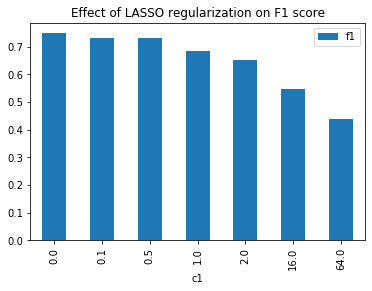

In [355]:
only_c1.plot.bar(x='c1', y='f1', style='x', title="Effect of LASSO regularization on F1 score")

# Mean c1

In [181]:
only_c1_mean = {}
for name, group in grid.groupby("c1"):
    only_c1_mean[str(name)] = group.f1.mean()

In [182]:
only_c1_mean

{'0.0': 0.8818332786630683,
 '0.1': 0.8841809090897066,
 '0.5': 0.8847285516451545,
 '1.0': 0.8805073226160044,
 '2.0': 0.8693292569175062,
 '16.0': 0.755034706057369,
 '64.0': 0.480203151083921}

In [183]:
import matplotlib.pyplot as plt

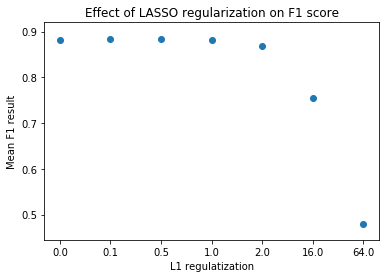

In [185]:
plt.ylabel('Mean F1 result')
plt.xlabel('L1 regulatization')
plt.title('Effect of LASSO regularization on F1 score')
plt.scatter(only_c1_mean.keys(), only_c1_mean.values())

In [490]:
for doc in X_train:
    for line in doc:
        for key, val in line.items():
            if isinstance(val, str):
                line[key] = val.replace("\r", "").replace("\n", " #NEWLINE ")

In [491]:
for doc in X_test:
    for line in doc:
        for key, val in line.items():
            if isinstance(val, str):
                line[key] = val.replace("\r", "").replace("\n", " #NEWLINE ")

# Test/train

In [492]:
tagger = sklearn_crfsuite.CRF(algorithm='lbfgs', c1=0.5, c2=0.1, min_freq=0.0)
tagger.fit(X_train, y_train)

CRF(algorithm='lbfgs', c1=0.5, c2=0.1, keep_tempfiles=None, min_freq=0.0)

In [532]:
scoring_classes = [c for c in tagger.classes_ if c not in ["no_entity", "DIV"]]

In [533]:
from sklearn_crfsuite import metrics
y_pred = tagger.predict(X_test)
metrics.flat_f1_score(y_test, y_pred, average='weighted', labels=scoring_classes)*100

78.32309003586342

In [534]:
print(metrics.flat_classification_report(y_test, y_pred, digits=3, labels=scoring_classes))

              precision    recall  f1-score   support

      PERSON      0.929     0.812     0.867        32
       TITLE      1.000     0.500     0.667        10
         ORG      0.545     1.000     0.706        18
     ADDRESS      1.000     0.409     0.581        22
       PHONE      0.923     0.923     0.923        26
         FAX      1.000     0.900     0.947        10
       EMAIL      1.000     0.500     0.667         4
         URL      1.000     0.500     0.667         4

   micro avg      0.833     0.754     0.792       126
   macro avg      0.925     0.693     0.753       126
weighted avg      0.901     0.754     0.783       126



G:\Programs\Anaconda2\envs\thesis-enron\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=['PERSON', 'TITLE', 'ORG', 'ADDRESS', 'PHONE', 'FAX', 'EMAIL', 'URL'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [495]:
X_train[0][1]

{'email': False,
 'url': False,
 'num': False,
 'stop': False,
 'alpha': False,
 'title': False,
 'first': False,
 'last': False,
 'job': False,
 'job_part': False,
 'spacy': 'no_entity',
 'prefix3': ',',
 'line_prefix3': 'Sin',
 'line_suffix3': 'y, #NEWLINE ',
 'shape': ',',
 '-1:email': False,
 '-1:url': False,
 '-1:num': False,
 '-1:stop': False,
 '-1:alpha': True,
 '-1:title': True,
 '-1:first': False,
 '-1:last': False,
 '-1:job': False,
 '-1:job_part': False,
 '-1:spacy': 'no_entity',
 '-1:prefix3': 'Sin',
 '-1:line_prefix3': 'Sin',
 '-1:line_suffix3': 'y, #NEWLINE ',
 '-1:shape': 'Xxxxx',
 '+1:email': False,
 '+1:url': False,
 '+1:num': False,
 '+1:stop': False,
 '+1:alpha': False,
 '+1:title': False,
 '+1:first': False,
 '+1:last': False,
 '+1:job': False,
 '+1:job_part': False,
 '+1:spacy': 'no_entity',
 '+1:prefix3': ' #NEWLINE ',
 '+1:line_prefix3': 'Sin',
 '+1:line_suffix3': 'y, #NEWLINE ',
 '+1:shape': ' #NEWLINE '}

In [546]:
import eli5
eli5.explain_weights(tagger, top=(5,10))

G:\Programs\Anaconda2\envs\thesis-enron\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


From \ To,ADDRESS,DIV,EMAIL,FAX,ORG,PERSON,PHONE,TITLE,URL,no_entity
ADDRESS,4.293,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DIV,0.0,3.379,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.275
EMAIL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FAX,0.0,0.0,0.0,3.017,0.0,0.0,0.0,0.0,0.0,0.0
ORG,0.0,0.0,0.0,0.0,3.339,0.0,0.0,0.0,0.0,0.0
PERSON,0.0,0.0,0.0,0.0,0.0,2.033,0.0,0.0,0.0,0.155
PHONE,0.0,0.0,0.0,0.0,0.0,0.0,4.138,0.0,0.0,0.0
TITLE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.754,0.0,0.0
URL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
no_entity,0.0,0.0,0.488,0.0,-0.416,0.0,0.632,-0.003,0.0,2.453


In [545]:
for i, doc in enumerate(test):
    for j, line in enumerate(doc):
        if line["label"] == "DIV":
            print(f'{line["token"]:10} | {line["filename"]:40} | {y_pred[i][j]:10} | {line["spacy"]}')
#             print(f'{line["token"]:15} | {line["filename"]:40} | no prediction | {line["job_part"]}')

Client     | badeer-r_all_documents_119.txt           | DIV        | no_entity
Relations  | badeer-r_all_documents_119.txt           | DIV        | no_entity
Office     | dasovich-j_all_documents_21165.txt       | ORG        | ORG
of         | dasovich-j_all_documents_21165.txt       | ORG        | ORG
the        | dasovich-j_all_documents_21165.txt       | ORG        | ORG
Assembly   | dasovich-j_all_documents_21165.txt       | ORG        | ORG
Republican | dasovich-j_all_documents_21165.txt       | ORG        | NORP
Leader     | dasovich-j_all_documents_21165.txt       | ORG        | no_entity
